# General visualizations

This notebook presents the Ising model, the single-site Markov-chain Monte-Carlo (MCMC) and Wolff algorithms. Demonstrates general observations like cluster size in the Wolff algorithm based on the temperature, and its cutoff because of the finite grid.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from ising_common_procedures import *
from tqdm import trange,tqdm

plot_colors=['tab:blue','tab:orange','tab:green','tab:red']

## Example: Metropolis-Hastings - one sweep

In [2]:
# since J=100, after the 4th sweep the spins probably point to the same direction
config=init_grid((3,4))
print(config)
metropolis_hastings_sweep(config,1, 100)
print(config)
metropolis_hastings_sweep(config,1, 100)
print(config)
metropolis_hastings_sweep(config,1, 100)
print(config)
# measure magnetic moment (sum of spins) and energy
measure(config,100)

[[ 1 -1  1  1]
 [-1  1 -1 -1]
 [ 1 -1  1  1]]
[[ 1  1  1  1]
 [-1  1  1  1]
 [-1  1  1  1]]
[[-1  1  1  1]
 [-1  1  1  1]
 [ 1  1  1  1]]
[[ 1  1  1  1]
 [-1  1  1  1]
 [ 1  1  1  1]]


(10, -1600)

## Example: visualizing a cluster

In the beginning all the spins are up. Then, a wolff step is carried out from the middle spin.

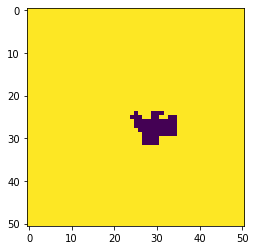

In [3]:
j=0.31
beta=1
arr=np.ones((51,51),dtype=np.int8)
acc=np.zeros(arr.shape)
wolff_step_at(arr,beta,j,25,25)
plt.imshow(arr,vmin=-1,vmax=1)
plt.show()

Now the same thing, but repeated 1000 times and averaged:

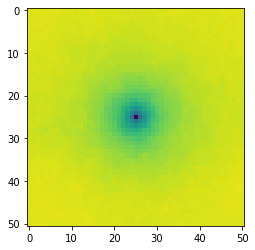

In [4]:
j=0.31
beta=1
arr=np.ones((51,51),dtype=np.int8)
acc=np.zeros(arr.shape)
for i in range(0,1000):
    arr.fill(1)
    wolff_step_at(arr,beta,j,25,25)
    acc+=arr
plt.imshow(acc/1000,vmin=-1,vmax=1)
plt.show()

## Example: Wolff - average cluster size in different grid sizes

The plot is relative to the whole grid: 1 means that the cluster is the whole grid.

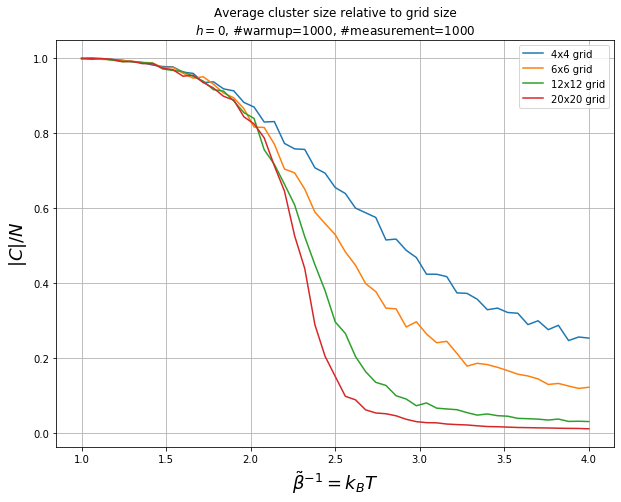

In [6]:
fig_c, ax=plt.subplots(1,1, figsize=(10,7.5))
# constants
num_points=51
num_warmup=1000
num_meas=1000
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
cluster_result=np.zeros(num_meas)
beta_inv_values=np.linspace(1,4,num_points)
j=1
# calculate and plot
for n in [4,6,12,20]:
    # data to plot
    res=[]
    for beta_inv in beta_inv_values:
        beta=1/beta_inv
        # init random config
        arr=init_grid((n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res+=[np.average(cluster_result)/n/n]
    ax.plot(beta_inv_values,res,label=f'{n}x{n} grid')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$',fontsize=18)
ax.set_ylabel(r'$|C|/N$',fontsize=18)
ax.set_title(f'Average cluster size relative to grid size\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()

## Cluster size and susceptibility

Based on the fluctuation-dissipation theorem ([see here](http://micro.stanford.edu/~caiwei/me334/Chap12_Ising_Model_v04.pdf)),
$$\chi=\frac{\beta}{N}\left(\left\langle M^{2}\right\rangle -\left\langle M\right\rangle ^{2}\right)$$
where $M$ is the magnetization: $M=\sum_{i}s_{i}$, and $N$ is the number of sites.

On the other hand, Wolff's paper claims that
$$\frac{\left\langle M^{2}\right\rangle -\left\langle M\right\rangle ^{2}}{N}=\left\langle c\right\rangle$$
where $\left\langle c\right\rangle$ is the average size of a cluster.

In [35]:
data_c_chi_chi={}
data_c_chi_cluster={}
# constants
num_points=51
num_warmup=6000
num_meas=1000
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
cluster_result=np.zeros(num_meas)
beta_inv_values=np.linspace(1,4,num_points)
j=1
# calculate and plot
for i,n in enumerate([4,6,12,20]):
    # data to plot
    res_chi=[]
    res_cluster=[]
    for beta_inv in tqdm(beta_inv_values):
        beta=1/beta_inv
        # init random config
        arr=init_grid((n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res_cluster+=[np.average(cluster_result)]
        res_chi+=[np.var(m_result)/n/n]
    data_c_chi_chi[n]=res_chi
    data_c_chi_cluster[n]=res_cluster

100%|██████████| 51/51 [00:05<00:00,  8.64it/s]


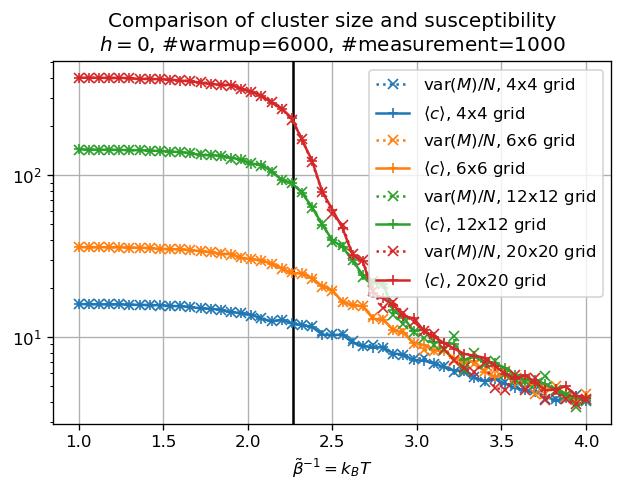

In [36]:
fig_c_chi, ax=plt.subplots(1,1,dpi=120)
plt.yscale('log')
ax.axvline(x=1/beta_c,color='black')
for i,n in enumerate(data_c_chi_chi):
    ax.plot(beta_inv_values,data_c_chi_chi[n],label=r'$\mathrm{var}\left(M\right)/N$'+f', {n}x{n} grid',linestyle=":",color=plot_colors[i],marker='x')
    ax.plot(beta_inv_values,data_c_chi_cluster[n],label=r'$\left\langle c\right\rangle$'+f', {n}x{n} grid',color=plot_colors[i],marker='+')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$')
ax.set_title(f'Comparison of cluster size and susceptibility\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()
fig_c_chi.savefig('images/general-c-chi-comparison.png')

## Cluster size and susceptibility in 3D

In [31]:
data_c_chi_3d_chi={}
data_c_chi_3d_cluster={}
# constants
num_points=51
num_warmup=3000
num_meas=1000
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
cluster_result=np.zeros(num_meas)
beta_inv_values=np.linspace(1,8,num_points)
j=1
# calculate and plot
for i,n in enumerate([5,10,15]):
    # data to plot
    res_chi=[]
    res_cluster=[]
    for beta_inv in tqdm(beta_inv_values):
        beta=1/beta_inv
        # init random config
        arr=init_grid((n,n,n))
        # warm up
        wolff_step(arr, beta, j, num_warmup)
        # measure
        wolff_measurement(arr, beta, j, cluster_result,m_result)
        # append magnetization to plot data
        res_cluster+=[np.average(cluster_result)]
        res_chi+=[np.var(m_result)/n/n/n]
    data_c_chi_3d_chi[n]=res_chi
    data_c_chi_3d_cluster[n]=res_cluster

100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


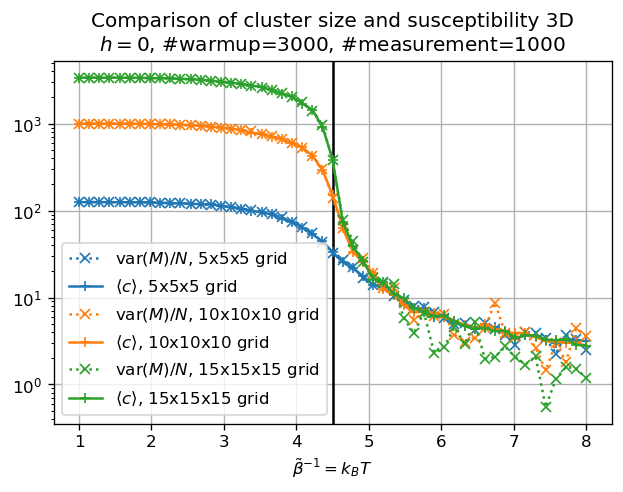

In [32]:
fig_c_chi_3d, ax=plt.subplots(1,1,dpi=120)
plt.yscale('log')
ax.axvline(x=1/beta_c_3d,color='black')
for i,n in enumerate(data_c_chi_3d_chi):
    ax.plot(beta_inv_values,data_c_chi_3d_chi[n],label=r'$\mathrm{var}\left(M\right)/N$'+f', {n}x{n}x{n} grid',linestyle=":",color=plot_colors[i],marker='x')
    ax.plot(beta_inv_values,data_c_chi_3d_cluster[n],label=r'$\left\langle c\right\rangle$'+f', {n}x{n}x{n} grid',color=plot_colors[i],marker='+')
ax.set_xlabel(r'$\tilde\beta^{-1}=k_B T$')
ax.set_title(f'Comparison of cluster size and susceptibility 3D\n$h=0$, #warmup={num_warmup}, #measurement={num_meas}')
ax.legend()
ax.grid()
fig_c_chi_3d.savefig('images/general-c-chi-comparison-3d.png')